# Evaluation of the fine-tuned CamemBERT model for span classification on the GeoEDdA dataset


This notebook shows the evaluation of the fine-tuned CamemBERT model for span classification on the GeoEDdA dataset.

The model is available on HuggingFace: 
https://huggingface.co/GEODE/camembert-base-edda-span-classification

We use the test set of the GeoEDdA dataset available also on HuggingFace:
https://huggingface.co/datasets/GEODE/GeoEDdA

For more details about the dataset and tagset used, see: https://github.com/GEODE-project/ner-spancat-edda

In [1]:
import torch
import pandas as pd
import numpy as np
from datasets import load_dataset, Dataset
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix
from sklearn_crfsuite.utils import flatten
from transformers import AutoTokenizer, AutoModelForTokenClassification, Trainer
import matplotlib.pyplot as plt
from pprint import pprint
from sklearn.metrics import classification_report
from collections import Counter
import seaborn as sns
from utils import filter_tags, format, get_data

In [2]:
device = torch.device("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))
device

device(type='mps')

In [3]:
dataset = load_dataset("GEODE/GeoEDdA")
df = pd.DataFrame(dataset['test'])
df.head()

,text,meta,tokens,spans
0,"COMPIEGNE, (Géog. mod.) ville de France, dans ...","{'volume': 3, 'head': 'COMPIEGNE', 'author': '...","[{'text': 'COMPIEGNE', 'start': 0, 'end': 9, '...","[{'text': 'COMPIEGNE', 'start': 0, 'end': 9, '..."
1,"HILPERHAUSEN, (Géog.) ville d'Allemagne en Fra...","{'volume': 8, 'head': 'HILPERHAUSEN', 'author'...","[{'text': 'HILPERHAUSEN', 'start': 0, 'end': 1...","[{'text': 'HILPERHAUSEN', 'start': 0, 'end': 1..."
2,"Patane ou Patany, (Géog. mod.) royaume des Ind...","{'volume': 12, 'head': 'Patane ou Patany', 'au...","[{'text': 'Patane', 'start': 0, 'end': 6, 'id'...","[{'text': 'Patane ou Patany', 'start': 0, 'end..."
3,"* ABYDE ou ABYDOS, sub. Ville maritime de Phry...","{'volume': 1, 'head': 'ABYDE ou ABYDOS', 'auth...","[{'text': '*', 'start': 0, 'end': 1, 'id': 0, ...","[{'text': 'ABYDE ou ABYDOS', 'start': 2, 'end'..."
4,"DUSSELDORP, (Géog. mod.) ville du cercle de We...","{'volume': 5, 'head': 'DUSSELDORP', 'author': ...","[{'text': 'DUSSELDORP', 'start': 0, 'end': 10,...","[{'text': 'DUSSELDORP', 'start': 0, 'end': 10,..."


In [4]:
tagset_filter = ['Head', 'Domain-mark', 'NC-Spatial', 'NC-Person', 'NP-Spatial', 'NP-Person', 'NP-Misc', 'Relation', 'Latlong']

df['tags'] = df.apply(lambda x:[' '.join(label) for label in filter_tags(x, tagset_filter, remove_nested=True)], axis=1)

In [5]:
model_base = "camembert-base"
model_name = 'camembert-base-edda-span-classification'

tokenizer = AutoTokenizer.from_pretrained(model_base, clean_up_tokenization_spaces=True)

model = AutoModelForTokenClassification.from_pretrained(model_name).to(device)

id2label = model.config.id2label
label2id = model.config.label2id

In [6]:
df['ids'] = df.apply(lambda x: format(list(x['tags']), label2id), axis=1)
df.head()

,text,meta,tokens,spans,tags,ids
0,"COMPIEGNE, (Géog. mod.) ville de France, dans ...","{'volume': 3, 'head': 'COMPIEGNE', 'author': '...","[{'text': 'COMPIEGNE', 'start': 0, 'end': 9, '...","[{'text': 'COMPIEGNE', 'start': 0, 'end': 9, '...","[Head, O, O, Domain-mark, Domain-mark, Domain-...","[3, 1, 1, 9, 9, 9, 9, 1, 5, 1, 0, 1, 7, 5, 5, ..."
1,"HILPERHAUSEN, (Géog.) ville d'Allemagne en Fra...","{'volume': 8, 'head': 'HILPERHAUSEN', 'author'...","[{'text': 'HILPERHAUSEN', 'start': 0, 'end': 1...","[{'text': 'HILPERHAUSEN', 'start': 0, 'end': 1...","[Head, O, O, Domain-mark, Domain-mark, O, NC-S...","[3, 1, 1, 9, 9, 1, 5, 1, 0, 7, 0, 1, 7, 0, 0, ..."
2,"Patane ou Patany, (Géog. mod.) royaume des Ind...","{'volume': 12, 'head': 'Patane ou Patany', 'au...","[{'text': 'Patane', 'start': 0, 'end': 6, 'id'...","[{'text': 'Patane ou Patany', 'start': 0, 'end...","[Head, Head, Head, O, O, Domain-mark, Domain-m...","[3, 3, 3, 1, 1, 9, 9, 9, 9, 1, 5, 1, 0, 7, 5, ..."
3,"* ABYDE ou ABYDOS, sub. Ville maritime de Phry...","{'volume': 1, 'head': 'ABYDE ou ABYDOS', 'auth...","[{'text': '*', 'start': 0, 'end': 1, 'id': 0, ...","[{'text': 'ABYDE ou ABYDOS', 'start': 2, 'end'...","[O, Head, Head, Head, O, O, O, NC-Spatial, NC-...","[1, 3, 3, 3, 1, 1, 1, 5, 5, 1, 0, 7, 7, 7, 7, ..."
4,"DUSSELDORP, (Géog. mod.) ville du cercle de We...","{'volume': 5, 'head': 'DUSSELDORP', 'author': ...","[{'text': 'DUSSELDORP', 'start': 0, 'end': 10,...","[{'text': 'DUSSELDORP', 'start': 0, 'end': 10,...","[Head, O, O, Domain-mark, Domain-mark, Domain-...","[3, 1, 1, 9, 9, 9, 9, 1, 5, 1, 5, 1, 0, 1, 5, ..."


In [7]:
data = get_data((df.to_dict('records')))

test_dataset = Dataset.from_list(data)

In [8]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True, padding="max_length")
    labels = []
    word_idss = []
    for i, label in enumerate(examples[f"tags_id"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i) 
        label_ids = []
        for j, word_idx in enumerate(word_ids):  
            if word_idx is None:
                label_ids.append(label2id['O'])
            else:
                label_ids.append(label[word_idx])
        labels.append(label_ids)
        word_idss.append(word_ids)
    tokenized_inputs["labels"] = labels
    tokenized_inputs['word_ids'] = word_idss
    return tokenized_inputs


In [9]:
tokenized_test_dataset = test_dataset.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [10]:
def divide(a: int, b: int):
    return a / b if b > 0 else 0


def compute_metrics(p):
    predictions, true_labels = p
    metrics = {}
    cm = multilabel_confusion_matrix(flatten(true_labels), [np.argmax(token) for sentence in predictions for token in sentence], labels=list(id2label.keys()))
    for label_idx, matrix in enumerate(cm):
        if id2label[label_idx] == 'O':
            continue
        tp, fp, fn = matrix[1, 1], matrix[0, 1], matrix[1, 0]
        precision = divide(tp, tp + fp)
        recall = divide(tp, tp + fn)
        f1 = divide(2 * precision * recall, precision + recall)
        metrics[f"f1_{id2label[label_idx]}"] = f1
    macro_f1 = sum(list(metrics.values())) / (len(list(id2label.keys())) - 1)
    metrics["macro_f1"] = macro_f1
    return metrics

In [11]:
def read_preds(y_pred, word_idss, id2label):
    preds = []
    need_print = False
    for y, word_ids in zip(y_pred, word_idss):
        if need_print:
            pprint(list(map(lambda x: id2label[x], pred)))
            need_print = False
        pred = []
        previous_tag = None
        previous_idx = -1
        need_vote = False
        votes = []
        for tag, idx in zip(y, word_ids):
            if idx != None:
                if idx != previous_idx:
                    if need_vote:
                        c = Counter(votes)
                        common = c.most_common(1)[0]
                        if pred[-1] != common[0] and common[1] != 1:
                            pred[-1] = common[0]
                    need_vote = False
                    votes = []
                    pred.append(tag)
                    previous_idx = idx
                    previous_tag = tag
                else:
                    votes.append(previous_tag)
        preds.append(pred)

    return preds

In [12]:
trainer = Trainer(
    model = model,
    compute_metrics = compute_metrics
)

y_pred = trainer.predict(tokenized_test_dataset).predictions.argmax(axis=-1)
y_true = tokenized_test_dataset['labels']
preds  = read_preds(y_pred, tokenized_test_dataset['word_ids'], id2label)

  0%|          | 0/25 [00:00<?, ?it/s]

In [13]:
preds_flat = [id2label[p] for pred in preds for p in pred]
trues = read_preds(y_true, tokenized_test_dataset['word_ids'], id2label)
trues_flat = [id2label[t] for true in trues for t in true]

In [14]:
print(classification_report(trues_flat, preds_flat, digits=3, labels=[tag for tag in label2id.keys() if tag!='O']))

              precision    recall  f1-score   support

 Domain-mark      0.990     1.000     0.995       392
        Head      0.973     0.980     0.976       254
     Latlong      0.970     0.985     0.977       789
   NC-Person      0.704     0.784     0.742       222
  NC-Spatial      0.897     0.953     0.924       592
     NP-Misc      0.690     0.829     0.753       175
   NP-Person      0.886     0.904     0.895       198
  NP-Spatial      0.967     0.951     0.959       717
    Relation      0.898     0.956     0.926       452

   micro avg      0.915     0.948     0.931      3791
   macro avg      0.886     0.927     0.905      3791
weighted avg      0.919     0.948     0.933      3791



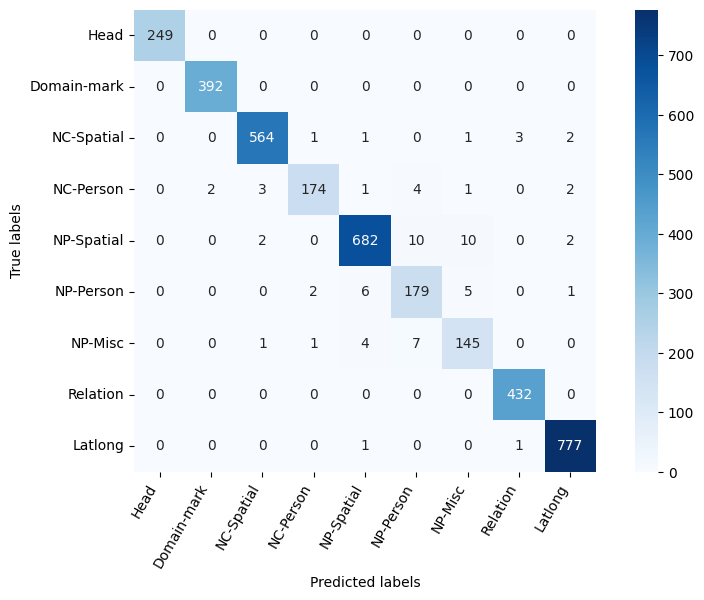

In [15]:
# Assuming you have the true labels and predicted labels stored in the variables true_labels and predicted_labels

# Compute the confusion matrix
cm = confusion_matrix(trues_flat, preds_flat)

# Get the unique class labels
class_labels = np.unique(np.concatenate((trues_flat, preds_flat)))

# Create a DataFrame from the confusion matrix
df_cm = pd.DataFrame(cm, index=class_labels, columns=class_labels)
df_cm = df_cm.loc[tagset_filter] # reorder
df_cm = df_cm[tagset_filter]



# Create a heatmap using seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='d', square=True)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.xticks(rotation=60, ha='right')
plt.show()